# Fine-Tuning a COVID CT-Scan Classification Model

NVIDIA Clara is a healthcare application framework for AI-powered imaging, genomics, and the development and deployment of smart sensors.

This Notebook uses the Clara Train SDK, NVIDIA’s domain optimized application framework that accelerates deep learning training and inference for medical imaging use cases, to fine tune a previously trained classifier to be able to classify data with different characteristics to the ones present in the data the model was trained on. 

Clara Train is a framework that includes two main libraries; AI-Assisted Annotation (AIAA), which enables medical viewers to rapidly create annotated datasets suitable for training, and a Training Framework, a TensorFlow based framework to kick start AI development with techniques like transfer learning, federated learning and AutoML. Clara Train utilizes a concept called MMAR (Medical Model ARchive) that describes a model, configuration, transforms, and data associated with the model.

The [Clara CT-Scan Covid Classifier](https://ngc.nvidia.com/catalog/models/nvidia:med:clara_train_covid19_3d_ct_classification) is used as a base model. This model is developed by NVIDIA researchers in conjunction with the NIH. It was trained and evaluated on a global dataset with thousands of experimental cohorts collected from across the globe. The model achieved an accuracy of greater than 90% on a test set consisting of more than one thousand CT images collected across the globe. The model requires two inputs, a CT scan image and a lung segmentation image, to guide the model to focus on the lung area. A CT scan, or computed tomography scan, is a 3D medical imaging procedure that uses computer-processed combinations of many X-ray measurements taken from different angles to produce cross-sectional (tomographic) images. Before training, the data is preprocesed to be in Hounsfield units and to be in certain orientation.

In this Jupyter Notebook, we will perform several steps. 

<img src="ctscanclassworkflow.png"
     alt="Markdown Monster icon"
     style="float: left; margin-right: 10px;" />




First, we will use this classifier to classify data that has not been preprocessed. Labelled data from two sources are used: 

* CT-scans from COVID patients on the [COVID-19 CT scans Kaggle Database](https://www.kaggle.com/andrewmvd/covid19-ct-scans) 
* CT-scans from non-COVID CT-scans from [The Cancer Imaging Archive](https://wiki.cancerimagingarchive.net/display/Public/LIDC-IDRI).

Given that some of the data is not preprocessed, the model will perform poorer on classifying some of the examples. The next step is to use the fine tuning capabilities of the Clara Train SDK to fine tune the model, after which the model can correctly classify some of the examples it misclassified at first.

The intent of this notebook is to showcase the features of the CLARA Train SDK, not to produce a research quality model.

The [Clara CT-Scan Covid Classifier](https://ngc.nvidia.com/catalog/models/nvidia:med:clara_train_covid19_3d_ct_classification) is for Research Use Only. Software’s recommendation should not be solely or primarily relied upon to diagnose or treat COVID-19 by a Healthcare Professional. This research use only software has not been cleared or approved by FDA or any regulatory agency.

## Installations Prerequisites

* A GPU-supported Compute Cluster
* The [Clara Train SDK] (https://ngc.nvidia.com/catalog/containers/nvidia:clara-train-sdk) image
* The [Clara CT-Scan Covid Classifier](https://ngc.nvidia.com/catalog/models/nvidia:med:clara_train_covid19_3d_ct_classification) has to be preloaded
* The new Data has to be preloaded

All these prerequisites (with the exception of one) could be automatically fullfiled by the use of the [AzureML-NGC Set Up Mechanism](https://github.com/drabastomek/azureml-ngc-tools)

#### Loading libraries

In [1]:
import TransformInputData as tid
import nibabel as nib
import matplotlib.pyplot as plt

The TransformInputData library contains a series of simple functions that transform the input data into the format expected by the Clara Train SDK. It also has functions that adapt the Clara MMAR configuration files from the base classifier to the desired specs for the new classifier, including labels, learning rate, and number of epochs.

#### Downloading Kaggle Data

The only prerequisite that can not be automatically done is downloading the set of new COVID CT-Scans from Kaggle as that requires a user assigned key that can be generated in the Kaggle site [(instructions)](https://github.com/Kaggle/kaggle-api#api-credentials). **The key should be downloaded on a config file named: kaggle.json and be uploaded on the workspaceblobstore/clara/ folder, the following cells expect the file to be present on the folder**

In [2]:
!pip install kaggle

You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [3]:
!cp kaggle.json /root/.kaggle
!kaggle datasets download -d "andrewmvd/covid19-ct-scans"

covid19-ct-scans.zip: Skipping, found more recently modified local copy (use --force to force download)


Unzipping the file into the data folder

In [4]:
tid.unzippedfile('experiments/kaggleset/','covid19-ct-scans.zip')

## Inspect the data

A CT scan, or computed tomography scan, is a 3D medical imaging procedure that uses computer-processed combinations of many X-ray measurements taken from different angles to produce cross-sectional (tomographic) images. 

The following line instructs the Notebook where to find the data:

In [5]:
kaggledata_dir='experiments/kaggleset/'

These functions help to visualize the data:

In [6]:
def get_ct_scan_data(filename):
    ct_scan_file = '{0}ct_scans/{1}'.format(kaggledata_dir,filename)
    lung_mask_file = '{0}lung_mask/{1}'.format(kaggledata_dir,filename)
    lung_mask_file  = lung_mask_file.replace('org_covid-19-pneumonia-','').replace('org_','').replace('-dcm','')
    lung_mask_file  = lung_mask_file.replace('LIDC-IDRI-','').replace('_1.nii.gz','.nii.gz')
    ct_scan_data = nib.load(ct_scan_file)
    lung_mask_data = nib.load(lung_mask_file)
    return ct_scan_data, lung_mask_data 

def show_ct_scan_data(ct_scan_data,lung_mask_data,num):
    plt.imshow(ct_scan_data.get_fdata()[:,:,num])
    plt.show()
    plt.imshow(lung_mask_data.get_fdata()[:,:,num])

Here we take three examples out from the data that we use to visualize and to test the performance of the model. These examples are not used in the re-tuning of the model:

| Example       | Description     |
| :------------- | :----------: |
|  coronacases_org_004.nii | A positive example with characteristics similar resulting from preprocessing the data   |
| radiopaedia_org_covid-19-pneumonia-14_85914_0-dcm.nii   | A positive example not in Hounsfield units and also not in anatomically correct orientation |
| LIDC-IDRI-0032_1.nii.gz   | A negative example |


In [7]:
testing=['coronacases_org_004.nii','radiopaedia_org_covid-19-pneumonia-14_85914_0-dcm.nii','LIDC-IDRI-0032_1.nii.gz']

Loading the data from the first example:

In [8]:
ct_scan_data, lung_mask_data = get_ct_scan_data(testing[0])
ct_scan_data.shape

(512, 512, 270)

We can observe that the data is, in fact, in three dimensions:

### Let's take a look at some of the images

#### First testing image (A positive example)

As we will be plotting in two dimensions, we need to specify which exact X-Ray (num) we want to analyze. Here, we will look at frame 50:

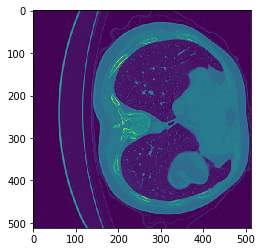

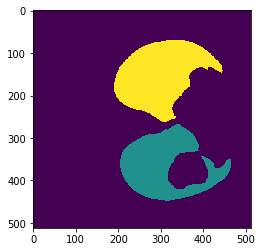

In [9]:
show_ct_scan_data(ct_scan_data,lung_mask_data,num=50)

There are two images, one for each of the required inputs to the model: the CT-Scan and the Lung Mask.

Inspecting another X-Ray for the same CT-Scan (Slice 100):

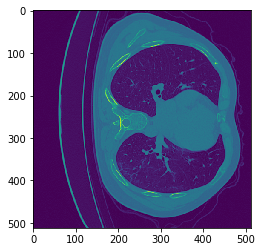

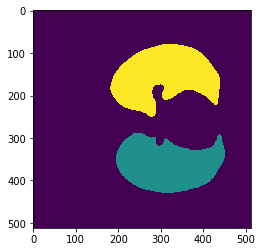

In [10]:
show_ct_scan_data(ct_scan_data,lung_mask_data,num=100)

#### Review Image Set 2 (Positive Example, Different Units)

In this example, we will view another CT exam, but the units are not the same as what the original model is expecting. This study uses pixel values; the model uses Hounsfield units (measuring radiodensity of the areas scanned). We will perform the same steps as before – look at the 3D aspect of the data, look at slice 50, and look at slice 100

In [11]:
ct_scan_data, lung_mask_data = get_ct_scan_data(testing[1])
ct_scan_data.shape

(630, 401, 110)

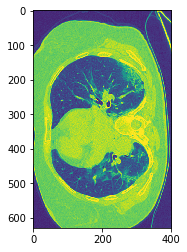

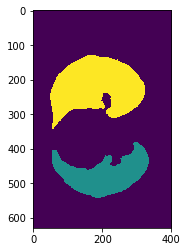

In [12]:
show_ct_scan_data(ct_scan_data,lung_mask_data,50)

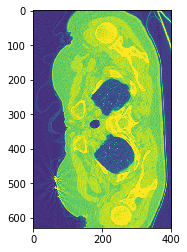

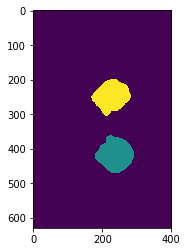

In [13]:
show_ct_scan_data(ct_scan_data,lung_mask_data,100)

Notice that the images in the second example look a bit different than the ones in the first example.  This is because the second example is not in Hounsfield units. 

#### Review Image Set 3 (Negative Example)

We will perform the same steps as before – look at the 3D aspect of the data, look at slice 50, and look at slice 100.

In [14]:
ct_scan_data, lung_mask_data = get_ct_scan_data(testing[2])
ct_scan_data.shape

(512, 512, 249)

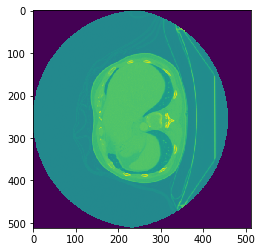

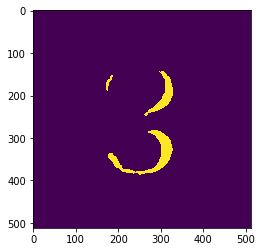

In [15]:
show_ct_scan_data(ct_scan_data,lung_mask_data,50)

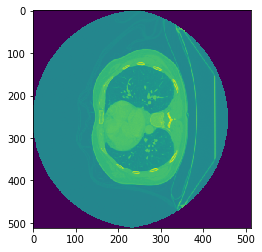

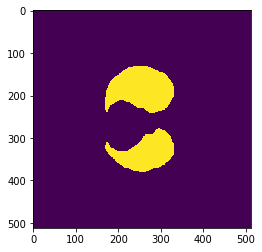

In [16]:
show_ct_scan_data(ct_scan_data,lung_mask_data,100)

## Validate Original Model

### Telling CLARA where to find the data

The CLARA Train SDK uses a specific JSON format to reference data. We need to convert the metadata from the data sources into the expected format.

Notice that we generate two files, one for the fine tuning of the model (dataFile) and one left for testing, containing the examples shown above.

In [17]:
inputFile = 'experiments/kaggleset/metadata.csv'
negativesFile =  'experiments/kaggleset/Ct-Scan-Negatives.txt'
dataFile = 'experiments/covid19_3d_ct_classification-v2/config/data_kaggle_train.json'
testingFile='experiments/covid19_3d_ct_classification-v2/config/data_kaggle_infer.json'
testing_full = ['ct_scans/{0}'.format(x) for x in testing]
validation_size=0.20
tid.transformCTScanMetadataToJSON(inputFile,negativesFile,dataFile,testingFile,kaggledata_dir,testing_full,validation_size)

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


## Lets run inference on the testing data with the model as it is

We are using the pretrained model as a base.

The pretrained model was preloaded on the relative folder experiments/covid19_3d_ct_classification-v2 .

The model folder, called MMAR, has six main subfolders:

* commands: Where all the scripts are stored
* config: Points to files where the user tells the system which data is to be used, what parameters are to be used, etc
* docs: Contains the license and a reference to more information about the model
* resources: Where the log files are stored
* models: The default location where the trained models are stored
* eval: The default location where inference results are stored


We need to adapt the files from the model that referenced the data that was used for its training and testing to the new sources of data. 

In [18]:
inputFile ='experiments/covid19_3d_ct_classification-v2/config/environment.json'
outputFile = 'experiments/covid19_3d_ct_classification-v2/config/infer_environment.json'
tid.adaptJSONFile(inputFile,outputFile,['DATASET_JSON','DATA_ROOT'],[testingFile,kaggledata_dir])

The infer.sh script runs inference of the original model on the data contained in the testingFile.

We need to adapt the script to point to the new testing data and the new environment.

In [19]:
inputFile = 'experiments/covid19_3d_ct_classification-v2/commands/infer.sh'
outputFile='experiments/covid19_3d_ct_classification-v2/commands/new_infer.sh'
oldValues=["$MMAR_ROOT/config/dataset_0.json","config/environment.json"]
newValues=[testingFile,"config/infer_environment.json"]
tid.adaptScript(inputFile,outputFile,oldValues,newValues)

#### Firing the inference procedure

In [20]:
!experiments/covid19_3d_ct_classification-v2/commands/new_infer.sh

MMAR_ROOT set to /mnt/batch/tasks/shared/LS_root/jobs/tutorialtesta1/azureml/claratest_1596500979_7fe00586/mounts/workspaceblobstore/clara/experiments/covid19_3d_ct_classification-v2/commands/..
2020-08-04 04:23:06.622995: I tensorflow/stream_executor/platform/default/dso_loader.cc:42] Successfully opened dynamic library libcudart.so.10.1


--------------------------------------------------------------------------
[[51482,1],0]: A high-performance Open MPI point-to-point messaging module
was unable to find any relevant network interfaces:

Module: OpenFabrics (openib)
  Host: 9871866ed2b94bc88f08d2edafc2cff0000000

Another transport will be used instead, although this may result in
lower performance.

NOTE: You can disable this warning by setting the MCA parameter
btl_base_warn_component_unused to 0.
--------------------------------------------------------------------------
Using TensorFlow backend.
2020-08-04 04:23:08,687 - nvmidl.utils.train_conf - INFO - Automatic Mixed Precision st

### Inspecting the inference results

Since we did not change the default parameters on infer.sh, the system stored the inferred predictions in the default folder and file: eval/preds_model.csv. 

The following lines read the results: 

In [21]:
labels=['No COVID', 'COVID']
predictions_file = 'experiments/covid19_3d_ct_classification-v2/eval/preds_model.csv'
results = tid.processCTScanPredictions(predictions_file,labels)


Inspecting the result for the first testing case (A positive one)

In [22]:
results[testing[0]]

'No COVID = 0.01203339; COVID = 0.98796654'

The model correctly classified the example as belonging to a COVID case.

Inspecting the result for the second testing case (A positive one)

In [23]:
results[testing[1]]

'No COVID = 0.99991715; COVID = 8.286655e-05'

The model misclassifies the example as a non-COVID case, presumably because the example is not in Hounsfield units. 

Inspecting the result for the third testing case (A negative one)

In [24]:
results[testing[2]]

'No COVID = 0.99940354; COVID = 0.000596442'

The model correctly classified the example as NOT belonging to a COVID case.

## Fine-Tune Model

Now that we have our validation results, we note that there is an opportunity to fine-tune the model to the training data on-hand. 

### Update Training Configuration

As in the case of inference, we need to tell the model where the training data can be found.

In [25]:
inputFile ='experiments/covid19_3d_ct_classification-v2/config/environment.json'
outputFile = 'experiments/covid19_3d_ct_classification-v2/config/new_environment.json'
tid.adaptJSONFile(inputFile,outputFile,['DATASET_JSON','DATA_ROOT'],[dataFile,kaggledata_dir])

In [26]:
inputFile ='experiments/covid19_3d_ct_classification-v2/config/config_train.json'
outputFile = 'experiments/covid19_3d_ct_classification-v2/config/new_config_train.json'
output_batch_size = 2
tid.adaptCTScanJSONTrainConfigFile(inputFile,outputFile,output_batch_size)

#### We need to instruct the fine tune command where to find the data and the number of epochs we want to use

In [27]:
inputFile = 'experiments/covid19_3d_ct_classification-v2/commands/train_finetune.sh'
outputFile='experiments/covid19_3d_ct_classification-v2/commands/new_train_finetune.sh'
numepochs = 30
oldValues=["/workspace/Data/COVID/COVID_Test_Data","${MMAR_ROOT}/config/dataset_0.json","config/environment.json","config/config_train.json","epochs=1"]
newValues=["experiments/kaggleset",dataFile,"config/new_environment.json","config/new_config_train.json","epochs={0}".format(numepochs)]
tid.adaptScript(inputFile,outputFile,oldValues,newValues)

#### Execute Fine-tune Script

In [28]:
!experiments/covid19_3d_ct_classification-v2/commands/new_train_finetune.sh

MMAR_ROOT set to /mnt/batch/tasks/shared/LS_root/jobs/tutorialtesta1/azureml/claratest_1596500979_7fe00586/mounts/workspaceblobstore/clara/experiments/covid19_3d_ct_classification-v2/commands/..
2020-08-04 04:24:00.455362: I tensorflow/stream_executor/platform/default/dso_loader.cc:42] Successfully opened dynamic library libcudart.so.10.1


--------------------------------------------------------------------------
[[51244,1],0]: A high-performance Open MPI point-to-point messaging module
was unable to find any relevant network interfaces:

Module: OpenFabrics (openib)
  Host: 9871866ed2b94bc88f08d2edafc2cff0000000

Another transport will be used instead, although this may result in
lower performance.

NOTE: You can disable this warning by setting the MCA parameter
btl_base_warn_component_unused to 0.
--------------------------------------------------------------------------
Using TensorFlow backend.
2020-08-04 04:24:02,275 - TrainConfiger - INFO - DETERMINISM IS ON
2020-08-04 04:24:02,

Once the training completes, review the statistics that were generated, including training accuracy, training loss, mean accuracy, and the time it took for the fine-tuning to complete.

## Preparing to Export the Tuned Model

After tuning the model, the result is not automatically saved nor exported; this needs to explicitly run by executing the export.sh procedure. The fine-tuning script stores the intermediate model result on the MMAR_ROOT/model_finetuned folder, where:

* MMAR_ROOT = experiments/covid19_3d_ct_classification-v2. 

We need to adapt the export.sh script to find the new model.

In [ ]:
inputFile = 'experiments/covid19_3d_ct_classification-v2/commands/export.sh'
outputFile='experiments/covid19_3d_ct_classification-v2/commands/new_export.sh'
oldValues=["$MMAR_ROOT/models"]
newValues=["$MMAR_ROOT/model_finetuned"]
tid.adaptScript(inputFile,outputFile,oldValues,newValues)

#### Executing the Updated Export Procedure

In [ ]:
!experiments/covid19_3d_ct_classification-v2/commands/new_export.sh


## Re-validate Tuned Model

Next, we will run inference on the testing data with the fine-tuned model. We need to let the system know that we are using the fine-tuned model and that we want to store the inference in a different location, “eval_finetuned”.

In [ ]:
inputFile ='experiments/covid19_3d_ct_classification-v2/config/environment.json'
outputFile = 'experiments/covid19_3d_ct_classification-v2/config/infer_finetuned_environment.json'
tid.adaptJSONFile(inputFile,outputFile,['DATASET_JSON','DATA_ROOT','MMAR_EVAL_OUTPUT_PATH','MMAR_CKPT_DIR'],[testingFile,kaggledata_dir,'eval_finetuned','model_finetuned'])

The script needs to be informed where to find the new configuration:

In [ ]:
inputFile = 'experiments/covid19_3d_ct_classification-v2/commands/infer.sh'
outputFile='experiments/covid19_3d_ct_classification-v2/commands/finetuned_infer.sh'
oldValues=["$MMAR_ROOT/config/dataset_0.json","config/environment.json"]
newValues=[testingFile,"config/infer_finetuned_environment.json"]
tid.adaptScript(inputFile,outputFile,oldValues,newValues)

In [ ]:
!experiments/covid19_3d_ct_classification-v2/commands/finetuned_infer.sh

### Inspect Inference Results with the Tuned Model

The system stored the inferred predictions in file: eval_finetuned/preds_model.csv. 

The following lines read the results: 

In [ ]:
labels=['No COVID', 'COVID']
predictions_file = 'experiments/covid19_3d_ct_classification-v2/eval_finetuned/preds_model.csv'
results = tid.processCTScanPredictions(predictions_file,labels)

### Inference Results on Tuned Model for Image Set 1 (Positive Example)

In [ ]:
results[testing[0]]

The model correctly classified the example as belonging to a COVID case.

### Inference Results on Tuned Model for Image Set 2 (Positive Example, Different Units)

In [ ]:
results[testing[1]]

#### This is significant; this differs from the original model. With the tuned model, the model correctly classifies the example as a COVID case. The fine tuning has made a difference.

### Inference Results on Tuned Model for Image Set 3 (Negative Example)

In [ ]:
results[testing[2]]

The model correctly classified the example as NOT belonging to a COVID case

##### The purpose of this notebook was to showcase the ease of use of the Clara Train SDK and how it could be used to fine tune a state of the art model, trained with global data, using your own data. The procedure depicted in this notebook is not a rigorous data science experiment, as we only had 40 new examples, but rather to illustrate how to use the tools provided on the Clara Train SDK. Now that you have an environment ready, you can train and fine-tune models, using any of the pre-trained models with your own data. Your platform is ready and equipped with advanced features like federated learning, automated mixed precision, and AutoML. 

##### This notebook is also meant to be used in conjuction with the [AzureML-NGC Set Up Mechanism](https://ngc.nvidia.com/catalog/all) to exemplify how easy is to set up cool application on AzureML using NVIDIA NGC content